# qPCR timecourse

In [224]:
import pandas as pd
import plotnine as pn

from scipy.stats import sem

Functions

In [123]:
phages=["bop","car","ccs1","ccs2","ccs3","ump","carl","bill","ben","sds1","sds2","pg2","pg9","pg11","pg13","v12"]
phage_to_upper = {"bop":"Bop",
                 "car":"Car",
                 "ccs1":"CCS1",
                 "ccs2":"CCS2",
                 "ccs3":"CCS3",
                 "ump":"Ump",
                 "carl":"Carl",
                 "bill":"Bill",
                 "ben":"Ben",
                 "sds1":"SDS1",
                 "sds2":"SDS2",
                 "pg2":"PG2",
                 "pg9":"PG9",
                 "pg11":"PG11",
                 "pg13":"PG13",
                 "v12":"V12"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]

def parse_phages(text):
    '''
    Takes in a text string with phages in it and returns a list of the phages
    '''
    text_lower = str.lower(text)
    phage_list = []
    #Deal with car and carl
    if "carl" in text_lower:
        phage_list.append("carl")
        text_lower = text_lower.replace("carl","")
    for phage in phages:
        if phage in text_lower:
            phage_list.append(phage)
    phage_list = [phage_to_upper[x] for x in phage_list]
    return(phage_list)

def mean(x):
    return(sum(x)/len(x))

Import data

In [124]:
#Import data
file = "data/qpcr_timepoint.txt"
raw_dat = pd.read_table(file)

#Format data
##Parse phages
raw_dat["Phage"] = raw_dat.cocktail.apply(func=parse_phages)
##Count phages
raw_dat["num_phages"] = raw_dat.Phage.apply(func=lambda x: len(x))
##Format time
raw_dat["timepoint"] = [int(x.strip("h")) for x in raw_dat.timepoint]
raw_dat = raw_dat.melt(id_vars = ['host','cocktail','condition','phage_measured','timepoint','Phage','num_phages'], 
                       value_vars = ["value1","value2","value3"],
                      var_name = "replicate")
raw_dat["cocktail_name"] = ["Cocktail " + str(x.split()[-2]) for x in raw_dat.cocktail]

raw_dat.head(4)

,host,cocktail,condition,phage_measured,timepoint,Phage,num_phages,replicate,value,cocktail_name
0,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,0,"[Carl, CCS2, Ben]",3,value1,8.262565,Cocktail 1
1,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,24,"[Carl, CCS2, Ben]",3,value1,9.104303,Cocktail 1
2,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,48,"[Carl, CCS2, Ben]",3,value1,9.493282,Cocktail 1
3,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,72,"[Carl, CCS2, Ben]",3,value1,9.355837,Cocktail 1


Plot "phage only" wells over time to ensure nothing weird is happening

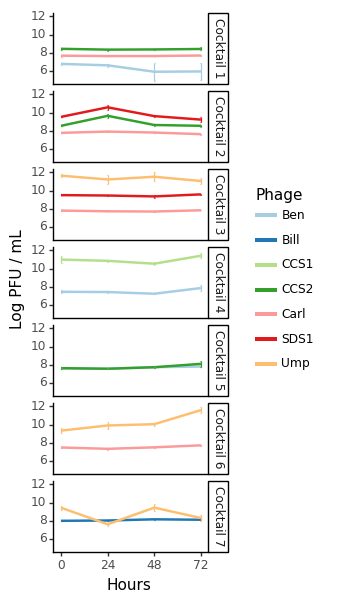

<ggplot: (8747657753986)>

In [125]:
plot_dat = raw_dat.query('condition=="no host"').copy()
plot_dat = plot_dat.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value':[mean,sem ]})\
    .reset_index()
plot_dat.columns = ["Cocktail","timepoint","phage_measured","value","err"]
plot_dat["errp"] = plot_dat.apply(axis=1, func = lambda row: row.value + row.err)
plot_dat["errn"] = plot_dat.apply(axis=1, func = lambda row: row.value - row.err)

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']

pn.options.figure_size = (2,7)

p = ( pn.ggplot( data = plot_dat) +
    pn.geom_line( pn.aes(x= "timepoint", y="value", color="phage_measured" ), size=1) +
     pn.geom_errorbar( pn.aes(x = "timepoint",  ymin = "errn", ymax = "errp", color="phage_measured")) +
     pn.scale_x_continuous(breaks = [0,24,48,72]) +
     pn.scale_color_manual(colors) +
     pn.labs(x="Hours", y="Log PFU / mL", color="Phage") +
     pn.facet_grid("Cocktail~.") +
     pn.theme_classic()
    
    )
p

In [145]:
mean_nohost_df.iloc[1:3].value

1    8.433143
2    7.676705
Name: value, dtype: float64

In [157]:
float(mean_nohost_df.query('phage_measured == "Ben" & cocktail_name == "Cocktail 1" & timepoint == 24').val)

6.6156656666666676

In [187]:
mean_nohost_df = raw_dat.query('condition=="no host"')\
                            .groupby(["cocktail_name","timepoint","phage_measured"])\
                            .agg({'value':[mean,sem ]})\
                            .reset_index()
mean_nohost_df.columns = ["cocktail_name", "timepoint","phage_measured","val","err"]


def subtraction_func(row):
    cocktail=row.cocktail_name
    phage = row["phage_measured"]
    timepoint = row.timepoint
    mean_nohost_val = float(mean_nohost_df.query('phage_measured == @phage & cocktail_name == @cocktail & timepoint == @timepoint').val)
    return(mean_nohost_val)



with_host_minus_nohost = raw_dat.query('condition=="with host"').copy()
with_host_minus_nohost["nohost_mean"] = with_host_minus_nohost.apply(axis=1, func=subtraction_func)
with_host_minus_nohost["value_minus_nohost"] = with_host_minus_nohost.apply(axis=1, func= lambda row: row.value - row.nohost_mean)

def format_cocktail_title(row):
    out = ''
    out +=  ' , '.join(row.Phage)
    return(out)

with_host_minus_nohost["formatted_cocktail_name"] = with_host_minus_nohost.apply(axis=1, func=format_cocktail_title)

In [214]:
phage_type_dict = {"Bop":"M",
                 "Car":"M",
                 "CCS1":"M",
                 "CCS2":"S",
                 "CCS3":"S",
                 "Ump":"P",
                 "Carl":"M",
                 "Bill":"M",
                 "Ben":"M",
                 "SDS1":"S",
                 "SDS2":"S",
                 "PG2":"S",
                 "PG9":"S",
                 "PG11":"S",
                 "PG13":"S",
                 "V12":"M"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]
phage_subtype = {x:"{}({})".format(x,phage_type_dict[x]) for x in phage_order}

/mnt/c/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


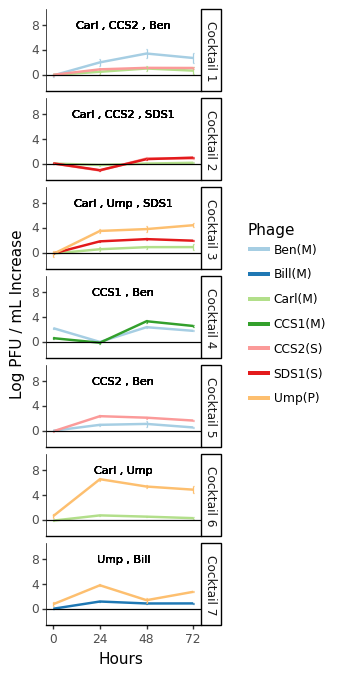

<ggplot: (8747655005368)>

In [216]:
plot_dat = with_host_minus_nohost.copy()
#Mean and err
plot_dat = plot_dat.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value_minus_nohost':[mean,sem ],
         "formatted_cocktail_name":"first"})\
    .reset_index()
plot_dat.columns = ["Cocktail","timepoint","phage_measured","value","err","formatted_cocktail_name"]
plot_dat["errp"] = plot_dat.apply(axis=1, func = lambda row: row.value + row.err)
plot_dat["errn"] = plot_dat.apply(axis=1, func = lambda row: row.value - row.err)
plot_dat["phage_measured"] = [phage_subtype[x] for x in plot_dat.phage_measured]
plot_dat["phage_measured"] = pd.Categorical(plot_dat["phage_measured"],
                                            categories=["Ben(M)","Bill(M)","Carl(M)","CCS1(M)", "CCS2(S)","SDS1(S)","Ump(P)"])


pn.options.figure_size = (2,8)
p = ( pn.ggplot(data = plot_dat) +
    pn.geom_line( pn.aes(x= "timepoint", y="value", color="phage_measured" ), size=1) +
     pn.geom_errorbar( pn.aes(x = "timepoint",  ymin = "errn", ymax = "errp", color="phage_measured")) +
     pn.geom_text( pn.aes(label="formatted_cocktail_name", x=36, y=8), size=8) +
     pn.geom_hline(pn.aes(yintercept=0)) +
     pn.scale_x_continuous(breaks = [0,24,48,72]) +
     pn.scale_y_continuous(limits = [-2,10], breaks=[0,4,8]) +
     pn.scale_color_manual(colors) +
     pn.labs(x="Hours", y="Log PFU / mL Increase", color="Phage", title="") +
     pn.facet_grid("Cocktail~", scales="free") +
     pn.theme_classic() +
     pn.theme(
         axis_line_y = pn.element_line(color="black", size = 0.5),
         panel_border= pn.element_blank())
    )

p

In [227]:
import numpy as np

/mnt/c/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


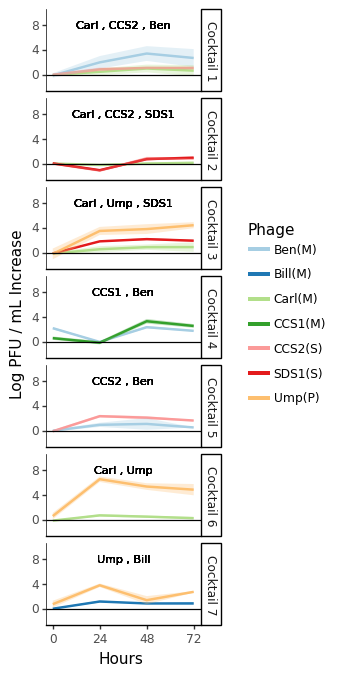

<ggplot: (8747662913046)>

In [230]:
plot_dat = with_host_minus_nohost.copy()
#Mean and err
plot_dat = plot_dat.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value_minus_nohost':[mean,np.std ],
         "formatted_cocktail_name":"first"})\
    .reset_index()
plot_dat.columns = ["Cocktail","timepoint","phage_measured","value","err","formatted_cocktail_name"]
plot_dat["errp"] = plot_dat.apply(axis=1, func = lambda row: row.value + row.err)
plot_dat["errn"] = plot_dat.apply(axis=1, func = lambda row: row.value - row.err)
plot_dat["phage_measured"] = [phage_subtype[x] for x in plot_dat.phage_measured]
plot_dat["phage_measured"] = pd.Categorical(plot_dat["phage_measured"],
                                            categories=["Ben(M)","Bill(M)","Carl(M)","CCS1(M)", "CCS2(S)","SDS1(S)","Ump(P)"])


pn.options.figure_size = (2,8)
p = ( pn.ggplot(data = plot_dat) +
    pn.geom_line( pn.aes(x= "timepoint", y="value", color="phage_measured" ), size=1) +
     pn.geom_ribbon( pn.aes(x = "timepoint",  ymin = "errn", ymax = "errp", fill="phage_measured"), alpha=.3, color=None) +
     pn.geom_text( pn.aes(label="formatted_cocktail_name", x=36, y=8), size=8) +
     pn.geom_hline(pn.aes(yintercept=0)) +
     pn.scale_x_continuous(breaks = [0,24,48,72]) +
     pn.scale_y_continuous(limits = [-2,10], breaks=[0,4,8]) +
     pn.scale_color_manual(colors) +
     pn.scale_fill_manual(colors) +
     pn.labs(x="Hours", y="Log PFU / mL Increase", color="Phage", title="") +
     pn.guides(fill=None) +
     pn.facet_grid("Cocktail~", scales="free") +
     pn.theme_classic() +
     pn.theme(
         axis_line_y = pn.element_line(color="black", size = 0.5),
         panel_border= pn.element_blank())
    )

p